# K-Means Implementation

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score

### Preprocessing the Data

In [3]:
df = pd.read_csv('football_data.csv').set_index('Unnamed: 0')

df_1=df[df['Position'].isna()==False]
df_1.loc[:,'Weight'] = df_1['Weight'].apply(lambda x: float(str(x).split('lbs')[0]) )

df_1.loc[:,'LS':'RB'] = df_1.loc[:,'LS':'RB'].fillna('0+0')

df_2 = df_1[df_1['Height'].isna()==False]

df_2.loc[:,'Height'] = df_2['Height'].apply(lambda x: float(str(x).split('\'')[0])*12 + float(str(x).split('\'')[1])  )

cols_pos = list(df_2.loc[:,'LS':'RB'].columns)

for col in cols_pos:
    df_2.loc[:,col] = df_2[col].apply(lambda x: float(str(x).split('+')[0]) + float(str(x).split('+')[1]) )
    
df=df_2


### Selecting the numeric values from the dataset

In [4]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
scaler = MinMaxScaler()
newdf = df.select_dtypes(include=numerics)

newdf.insert(0, "Name", list(df.Name), True)
newdf = newdf.drop(columns = ['ID','Jersey Number'])

### Scaling the data using MinMaxScaler

In [5]:
X = scaler.fit_transform(newdf.iloc[:,1:])
y = np.array(newdf.iloc[:,0])

### Applying PCA to reduce the features

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2) # 2D PCA for the plot
X = pd.DataFrame(pca.fit_transform(X)).to_numpy()


### K-means Algorithm from scratch

In [7]:
class KMeans:
    def __init__(self,K=5):
        self.K=K
        self.centers=[]
        self.X=[]
        self.clusters = dict()
        
    def metric(self,row1,row2):
        z=row1-row2
        z=z*z
        return z.sum()
    
    def init_centers(self,length):
        self.centers = []
        self.centers.append(self.X[np.random.randint(0,len(self.X)-1)])
        
        while len(self.centers) < self.K:
            dist = []
            for row in self.X:
                dist_row = []
                for centroid in self.centers:
                    dist_row.append(self.metric(centroid,row))
                dist.append(np.min(np.array(dist_row)))
            dist = np.array(dist)
            dist = dist / np.sum(dist)
            dist = np.cumsum(dist)
            r = np.random.rand(1)
            ind = np.min(np.where(dist>r))
            self.centers.append(self.X[ind])
    
    def init_cluster(self):
        for i in range(self.K):
            self.clusters[i] = []
            
    def fit(self,X_1):
        self.X = X_1
        length = len(X[0])
        self.init_centers(length)
        
        
        self.init_cluster()
        self.assign_cluster()
        new_centers = self.compute_centers()
        

        while np.linalg.norm(self.centers -new_centers) > 0.001:
            self.centers = new_centers
            
            self.init_cluster()
            self.assign_cluster()
            new_centers = self.compute_centers()
        

        self.compute_sse()
        self.predict()
        
    def assign_cluster(self):
        player = 0
        for row in self.X:
            sub = self.centers-row
            prod = sub*sub
            min_cluster = np.argmin(np.sum(prod,axis=1))

                
            self.clusters[min_cluster].append(player)     
            player += 1
            
    def compute_centers(self):
        new_centers = []
        for cluster in sorted(self.clusters.keys()):
            if len(self.clusters[cluster]) != 0:
                new_centers.append(np.sum(self.X[self.clusters[cluster],:],axis=0)/len(self.clusters[cluster]))
            else:
                new_centers.append(self.centers[cluster])
                
        return np.array(new_centers)
        
    def predict(self):
        
        self.predictions = [0 for i in range(len(self.X))]
        
        for i in self.clusters:
            label = i
            for data in self.clusters[i]:
                self.predictions[data] = label

    def compute_sse(self):
        self.sse = 0
        for i in range(self.K):
            center = self.centers[i]
            for data in self.clusters[i]:
                self.sse += self.metric(X[data],center)
                
                
        

### Plotting the Scatter Plot to show the clusters

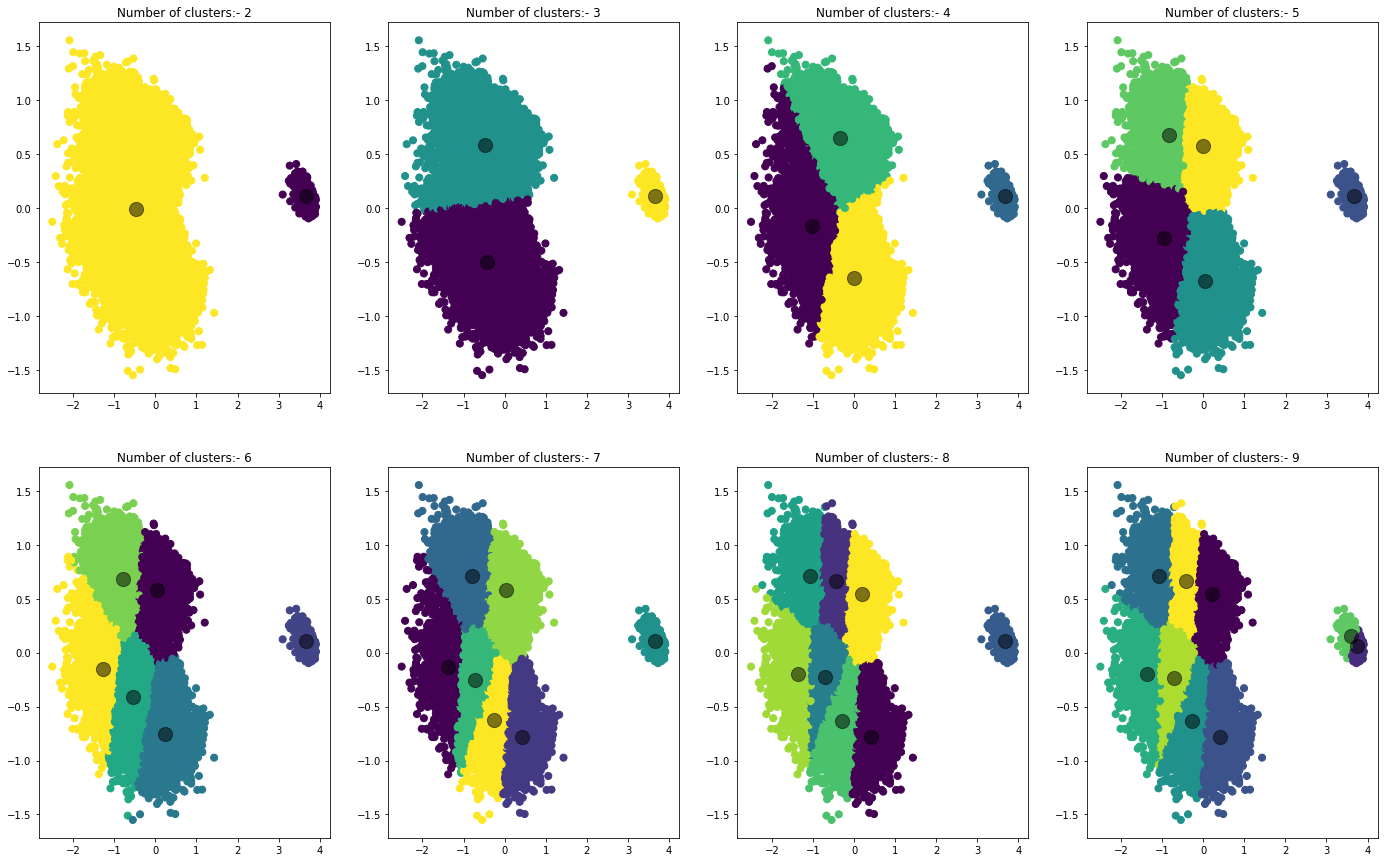

In [9]:
all_sse= []
all_K = []
sil = []

plt.figure(1, figsize=(24,15))

graph = 1

for i in range(2,10):
    
    model = KMeans(i)
    model.fit(X)
    
    ax = plt.subplot(2, 4, graph)

    ax.scatter(X[:, 0], X[:, 1], c=model.predictions, s=50, cmap='viridis')
    centers = model.centers
    ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

    ax.set_title("Number of clusters:- "+str(i))

    all_sse.append(model.sse)
    all_K.append(i)
    sil.append(silhouette_score(X,model.predictions,metric='euclidean'))
    
    graph += 1


**From the above scatter plots we can clearly see that the data is being clustered into two halves quite prominently. Let us now plot the silhouette scores and also using the least distances plot the elbow method graph below**

**Using Scatter Plots, we can see the inter-class and intra-class similarity by the distance of each cluster from the other**

- Over here, for K=2, the inter-class similarity is quite low thus giving us two distinct clusters in the graph


### Plotting the graph for Elbow Method

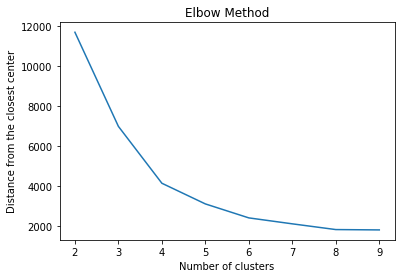

In [10]:
plt.plot(all_K[:],all_sse[:])
plt.xlabel("Number of clusters")
plt.ylabel("Distance from the closest center")
plt.title("Elbow Method")
plt.show()

**From the above graph, we cannot clearly determine the elbow point of the graph, so we are going to plot for the silhouette scores to find the optimal number of clusters for the given data**

### Plotting the graph for Silhouette Scores

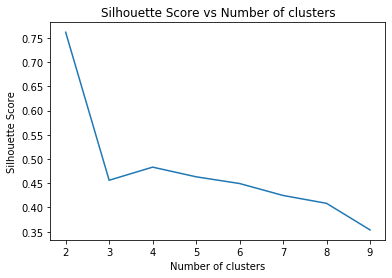

In [11]:
plt.plot(all_K[:],sil[:])
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of clusters")
plt.show()

**From the above graph, we can clearly determine the the optimal number of clusters for this dataset.** 

**In this graph, we can clearly see that at No. of cluster = 2, the silhouette score is maximum, thus giving us an optimal number of cluster.**

### Analysing the clusters formed at, K = 2 

In [83]:
model = KMeans(2)
model.fit(X)

**Goalkeepers together form a single cluster**

**All other players except the goalkeepers together form a single cluster**

In [84]:
for i in range(2):
    dict_pos = {}
    for pos in df.iloc[model.clusters[i],20].to_numpy():
        if pos not in dict_pos.keys():
            dict_pos[pos]=1
        else:
            dict_pos[pos]+=1
    print('Cluster Number',i,sorted(dict_pos.items(), key=lambda x: x[1], reverse=True)[:5])

Cluster Number 0 [('ST', 2152), ('CB', 1778), ('CM', 1394), ('LB', 1322), ('RB', 1291)]
Cluster Number 1 [('GK', 2025)]


### As it was told to plot the data for K = 3,4,5,6,7. We are plotting the elbow and silhouette scores for them

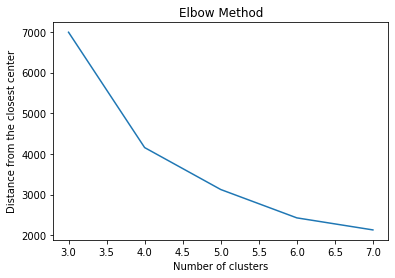

In [12]:
plt.plot(np.array(all_K)[[1,2,3,4,5]],np.array(all_sse)[[1,2,3,4,5]])
plt.xlabel("Number of clusters")
plt.ylabel("Distance from the closest center")
plt.title("Elbow Method")
plt.show()

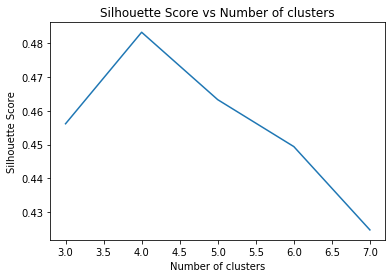

In [14]:
plt.plot(np.array(all_K)[[1,2,3,4,5]],np.array(sil)[[1,2,3,4,5]])
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of clusters")
plt.show()

**Among K=3,4,5,6,7, the optimal clustering happens at K=4, as we can see from the graphs above**

## Analysis of the Clusters Formed

In [22]:
model = KMeans(4)
model.fit(X)

- Cluster Number 0 mainly comprises of Defenders
- Cluster Number 1 mainly comprises of GoalKeepers
- Cluster Number 2 comprises a mix of Strikers,Wing and Attacking midfield players
- Cluster Number 3 mainly comprises of Central/Defending Midfielders

In [24]:
for i in range(4):
    dict_pos = {}
    for pos in df.iloc[model.clusters[i],20].to_numpy():
        if pos not in dict_pos.keys():
            dict_pos[pos]=1
        else:
            dict_pos[pos]+=1
    print('Cluster Number',i,sorted(dict_pos.items(), key=lambda x: x[1], reverse=True)[:5])

Cluster Number 0 [('CB', 1614), ('LB', 588), ('RB', 586), ('RCB', 549), ('LCB', 524)]
Cluster Number 1 [('GK', 2025)]
Cluster Number 2 [('ST', 2045), ('LM', 811), ('RM', 803), ('CAM', 674), ('RW', 323)]
Cluster Number 3 [('CM', 796), ('LB', 729), ('RB', 701), ('CDM', 560), ('RCM', 315)]
